This notebooks simply loads a generator model and spits a series of images

In [76]:
# from __future__ import print_function
%matplotlib inline
# import argparse #generates help messages
import os
import random
import sys
import torch
import torch.nn as nn
from torchvision.utils import save_image
# import torch.nn.parallel # implements data parallelism across multiple devices/GPUs
# import torch.backends.cudnn as cudnn
# import torch.nn.functional as F
# import torch.optim as optim # optimizer for example optim.Adam([var1, var2], lr=0.0001)
# import torch.utils.data # for the dataloader class (python iterable over a dataset)
import torchvision.datasets as dset # all datasets available in torch vision. not sure if needed here
import torchvision.transforms as transforms # all transformations for data augmentation (pad, resize, centercrop, ...)
import torchvision.utils as vutils # draw bounding box, segmantation mask, keypoints. convert to rgb, make grid, save_image
import numpy as np
import matplotlib.pyplot as plt
# import matplotlib.animation as animation
# import optuna
# from optuna.trial import TrialState
import logging
# from IPython.display import HTML # to embed html in the Ipython output
# import datetime
# import mlflow
sys.path.append("../src/models/")
sys.path.append("../src/utils/")
from Generator import OptGen
from Discriminator import OptDis
sys.path.append("../src/visualization/")
from utils import normalizeRGB, pixel_to_class, img_to_class, batch_to_class
from OptimisationFunctions import trainModel

logging.basicConfig(level=logging.WARNING)
logging.basicConfig(filename='../reports/MVPOptimizer.log') 

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

%load_ext autoreload
%autoreload 2

Random Seed:  999
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1 Load Models

In [9]:
imgFld = '../../cadastralExportRGB/cadastralRGB'
dataroot = "../../png/train"

In [10]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(imgFld) if isfile(join(imgFld, f))]
len(onlyfiles)

972

In [11]:
onlyfiles = [f for f in listdir(dataroot) if isfile(join(dataroot, f))]
len(onlyfiles)

103

In [12]:
src = '../models/MVPBestGenerator'

In [143]:
GNet = torch.load(src)
SatelliteGNet = torch.load('../models/WGANSatalliteGenerator') #SyntheticCities/models/WGANSatalliteGenerator
JNB7GNet = torch.load('../models/07NotebookWGANFuncGenerator')
CadastralGNetGreyscale = torch.load('../models/WGAN_CadastralGreyscale_Generator')
CadastralGNetRGB = torch.load('../models/WGANRGBGenerator') # SyntheticCities/models/WGAN_CadastralRGB_Generator

In [144]:
b_size = 64
nz = 100
ngpu = torch.cuda.device_count()
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [145]:
# Generate batch of latent vectors
noise = torch.randn(b_size, nz, 1, 1, device=device)
# Generate fake image batch with G
fake = GNet(noise).detach().cpu()
fakeSatellite = SatelliteGNet(noise).detach().cpu()
fakeJNB = JNB7GNet(noise).detach().cpu()
fakeCadastral = CadastralGNetGreyscale(noise).detach().cpu()
fakeCadastralRGB = CadastralGNetRGB(noise).detach().cpu()

### Model from Cadastral GAN optimisation Notebook

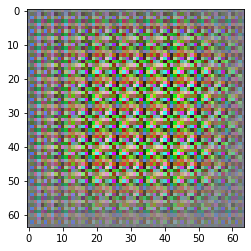

In [16]:
i = random.sample(range(b_size), 1)[0]
plt.imshow(normalizeRGB(fake[i]).permute(1,2,0));

### Model from WGAN notebook

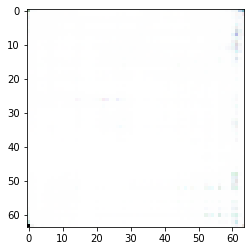

In [182]:
i = random.sample(range(b_size), 1)[0]
plt.imshow(normalizeRGB(fakeSatellite[i]).permute(1,2,0));

### Model after 500 epochs with no optimisation

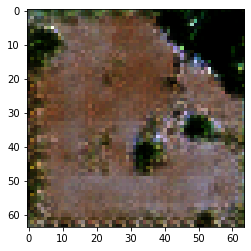

In [187]:
i = random.sample(range(b_size), 1)[0]
plt.imshow(normalizeRGB(fakeJNB[i]).permute(1,2,0));

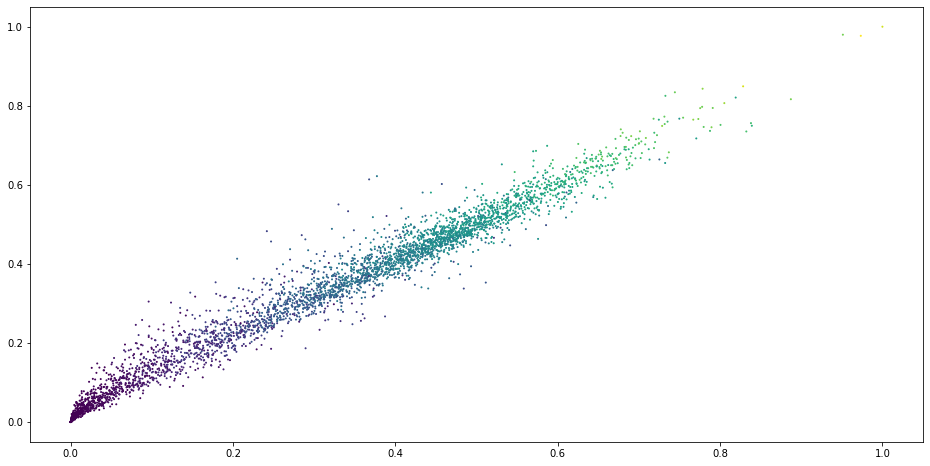

In [28]:
plt.figure(figsize=(16, 8))
plt.scatter(fakeJNB[i][0], fakeJNB[i][1], c = fakeJNB[i][2], s = 1 );

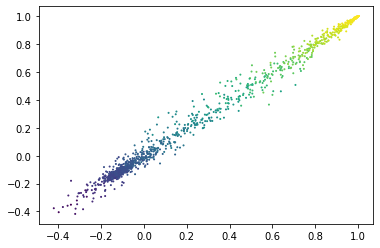

In [188]:
plt.scatter(fakeSatellite[i][0], fakeSatellite[i][1], c = fakeSatellite[i][2], s = 1);

### Cadastral Image Generator with Colors

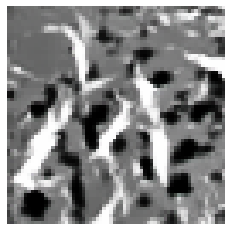

In [195]:
i = random.sample(range(b_size), 1)[0]
plt.figure(figsize=(4,4))
plt.axis('off')
plt.imshow(normalizeRGB(fakeCadastral[i]).permute(1,2,0));

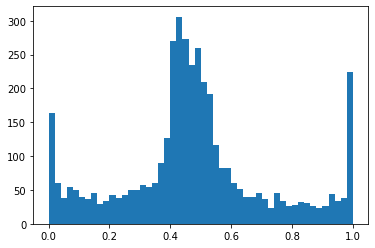

In [198]:
plt.hist(fakeCadastral[i][0].flatten().tolist(), bins = 50);

In [39]:
def regularize(x: float, threshold: float = 0.75):
    '''
    regularize the value of the input x to one of the three standard values 0, 1.5 and 3
    dimgray = 41.18%
    '''
    if x <= threshold:
        x = 0
    elif x >= 3 - threshold:
        x = 1
    else:
        x = 0.4118
    return x

def postprocess_cadastral(img: torch.Tensor, threshold: float = 0.75):
    '''
    postprocesses an image generated by a GNet
    '''
    values = img.sum(axis=0).apply_(lambda m: regularize(m, threshold = threshold)) #(regularize)
    res = torch.cat([values, values, values])
    res = res.view(-1, 64, 64)
    return res

def postprocess_batch(batch: torch.Tensor, threshold: float = 0.75):
    '''
    postprocess a batch of images generated by a GNet
    '''
    res = torch.stack([
    postprocess_cadastral(x_i, threshold = threshold) for i, x_i in enumerate(torch.unbind(batch, dim=0), 0)], dim=0) 
    return res
# batch.apply_(lambda m: postprocess_cadastral(m, threshold = threshold)) 

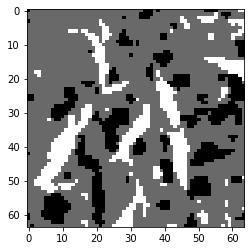

In [203]:
plt.imshow(postprocess_cadastral(fakeCadastral[i], threshold=0.75).permute(1,2,0));

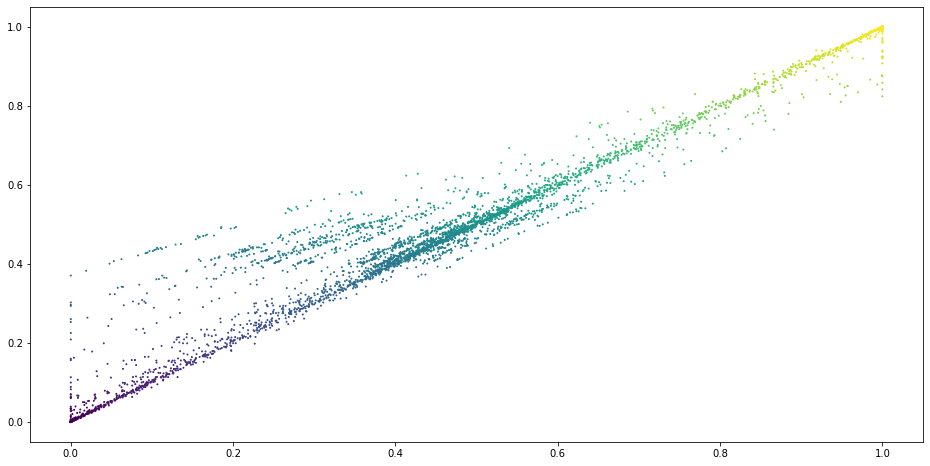

In [204]:
plt.figure(figsize=(16, 8))
plt.scatter(fakeCadastral[i][0], fakeCadastral[i][1], c = fakeCadastral[i][2], s = 1 );

### Cadastral Image Generator with class probabilities

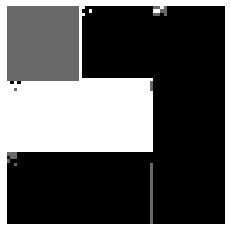

In [223]:
i = random.sample(range(b_size), 1)[0]
plt.figure(figsize=(4,4))
plt.axis('off')
plt.imshow(img_to_class(fakeCadastralRGB[i]).permute(1,2,0));

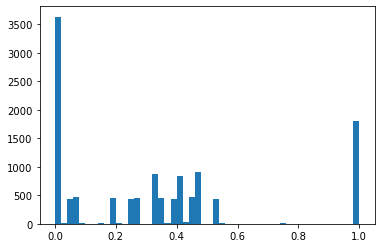

In [224]:
plt.hist(fakeCadastralRGB[i].flatten().tolist(), bins = 50);

In [225]:
fakeCadastralRGB[i].permute(1,2,0)[i][i]

tensor([2.7018e-17, 1.0000e+00, 1.5744e-15])

In [226]:
fakeCadastralRGB[i].sum(0)

tensor([[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        ...,
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]])

#### Comparing with the distribution in the real images

In [227]:
cadastralRoot = '../../cadastralExportRGB'
image_size = 64
batch_size = 64
workers = 2

# We can use an image folder dataset the way we have it setup
if os.path.exists(cadastralRoot + '/.ipynb_checkpoints'):
    shutil.rmtree(cadastralRoot + '/.ipynb_checkpoints')

Cad_dataset = dset.ImageFolder(root=cadastralRoot,
                           transform=transforms.Compose([
                               transforms.RandomRotation(degrees=(0,180), expand = False),
                               transforms.CenterCrop(image_size * 11),
                               transforms.Resize(image_size),
                               # transforms.RandomCrop(image_size),
                               transforms.ToTensor(),
                               # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), -> 
                           ]))
# Create the dataloader
Cad_dataloader = torch.utils.data.DataLoader(Cad_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)
Cad_real_batch = next(iter(Cad_dataloader))

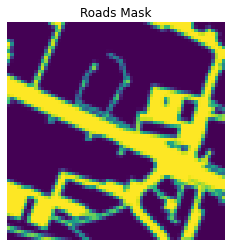

In [228]:
plt.title('Roads Mask')
plt.axis('off')
plt.imshow(Cad_real_batch[0][i][0]);

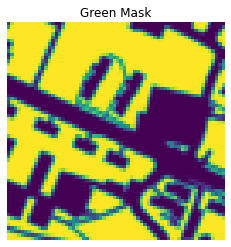

In [229]:
plt.title('Green Mask')
plt.axis('off')
plt.imshow(Cad_real_batch[0][i][1]);

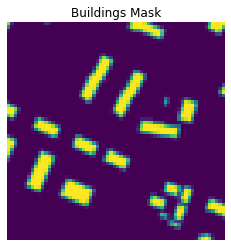

In [230]:
plt.title('Buildings Mask')
plt.axis('off')
plt.imshow(Cad_real_batch[0][i][2]);

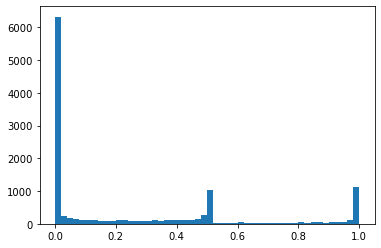

In [231]:
i = random.sample(range(b_size), 1)[0]
plt.hist(Cad_real_batch[0][i].flatten().tolist(), bins = 50);

In [57]:
fakeCadastralRGB[i].flatten()

tensor([0.5407, 0.4100, 0.2974,  ..., 0.7019, 0.3155, 0.3329])

In [55]:
fakeCadastralRGB[i][0][0][0]+fakeCadastralRGB[i][1][0][0]+fakeCadastralRGB[i][2][0][0]

tensor(1.)

In [58]:
fakeCadastralRGB[i]

tensor([[[0.5407, 0.4100, 0.2974,  ..., 0.3069, 0.4314, 0.1695],
         [0.3661, 0.2270, 0.3298,  ..., 0.1933, 0.2301, 0.2005],
         [0.3001, 0.1280, 0.2216,  ..., 0.2692, 0.3807, 0.3014],
         ...,
         [0.3762, 0.1324, 0.1815,  ..., 0.6378, 0.2179, 0.2949],
         [0.5526, 0.5456, 0.4590,  ..., 0.1335, 0.4379, 0.4745],
         [0.2552, 0.3785, 0.4122,  ..., 0.1553, 0.5865, 0.4732]],

        [[0.1361, 0.1034, 0.1342,  ..., 0.1855, 0.1610, 0.1042],
         [0.1615, 0.1673, 0.0649,  ..., 0.4999, 0.2677, 0.1139],
         [0.1495, 0.2198, 0.1851,  ..., 0.2596, 0.3128, 0.2671],
         ...,
         [0.1400, 0.3292, 0.2546,  ..., 0.0966, 0.1939, 0.1577],
         [0.1400, 0.0453, 0.2782,  ..., 0.1801, 0.1844, 0.1314],
         [0.2112, 0.1432, 0.2172,  ..., 0.1429, 0.0980, 0.1939]],

        [[0.3232, 0.4866, 0.5684,  ..., 0.5076, 0.4076, 0.7263],
         [0.4724, 0.6057, 0.6053,  ..., 0.3068, 0.5022, 0.6856],
         [0.5504, 0.6522, 0.5933,  ..., 0.4712, 0.3066, 0.

In [106]:
import torch.optim as optim
optimizerDCadastral = optim.Adam(GNet.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [111]:
type(GNet)

[autoreload of OptimisationFunctions failed: Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/opt/anaconda3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 455, in superreload
    module = reload(module)
  File "/opt/anaconda3/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 846, in exec_module
  File "<frozen importlib._bootstrap_external>", line 983, in get_code
  File "<frozen importlib._bootstrap_external>", line 913, in source_to_code
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/home/furio/SyntheticCities/notebooks/../src/utils/OptimisationFunctions.py", line 70
    epochs: int = 10, nz: int = 100, fixed_noise:torch.Tensor

Generator.OptGen